In [2]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.utils import plot_model
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
import xgboost as xgb 
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
import os
import scipy.io as sio

In [3]:
sr = 100
quick_load = True

In [5]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    def load_data():
        ptb = pd.read_csv('../../data/ptbxl_database.csv')
        def load_raw_data(df, sampling_rate, path):
            if(sampling_rate == 100):
                data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
            else:
                data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
            data = np.array([signal for signal, meta in data])
            return data
        
        # load and convert annotation data
        Y = pd.read_csv('../../data/ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Load raw signal data
        X = load_raw_data(Y, sr, '../../data/')

        # Load scp_statements.csv for diagnostic aggregation
        agg_df = pd.read_csv('../../data/scp_statements.csv', index_col=0)
        agg_df = agg_df[agg_df.diagnostic == 1]

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in agg_df.index:
                    tmp.append(agg_df.loc[key].diagnostic_class)
            return list(set(tmp))


        # Apply diagnostic superclass
        Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


if(quick_load):
    X = np.load('../../data/X_raw.npy')
    Y = pd.read_csv('../../data/Y_raw.csv')
else:
    X,Y = load_data()

In [7]:
gen_X_2000 = np.load('../../data/fake_ecgs/2000_generated_ecg_signals.npy')
gen_X_10000 = np.load('../../data/fake_ecgs/10000_generated_ecg_signals.npy')

In [5]:

import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [6]:

with tf.device('/GPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best
    
    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X
    gen_X_final_2000 = da_apply(gen_X_2000, func_dict)
    gen_X_final_10000 = da_apply(gen_X_10000, func_dict) 

In [7]:
def data_subsetting(X, Y):

        Y_filtered = Y.age
        Y_filtered = Y_filtered.to_numpy()

        X_filtered = X[(Y_filtered < 89) & (Y_filtered >= 18)] # Additional filtering of patients older than 89 and younger than 18
        Y_filtered = Y_filtered[(Y_filtered < 89) & (Y_filtered >= 18)]
        Y_filtered_full = Y[(Y.age < 89) & (Y.age >= 18)]

        return X_filtered, Y_filtered, Y_filtered_full

X_filtered, Y_filtered, Y_filtered_full = data_subsetting(X_final, Y)

In [8]:
def extract_features(model, layer_name, X):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    X_features = feature_extraction_model.predict(X)
    return X_features

def hybrid_prediction(cnn_model, xgb_model, X_new):
    # Extract features for new data using CNN-LSTM model
    X_new_features = extract_features(cnn_model, 'flatten', X_new)
    
    # Use XGBoost model to predict based on these features
    predictions = xgb_model.predict(X_new_features)
    
    return predictions

In [8]:
cnn_rnn_age_model = tf.keras.models.load_model('../../saved_models/100hz/age_models/cnn_rnn_age_model_8.03/')

# Make sure that the xgb model is the one associated with the cnn-lstm model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.load_model('../../saved_models/boost_models/100hz/age_models/xgb_model_8.03.json')  # Make sure the file name matches the one used for saving


In [15]:
with tf.device("/CPU:0"):
    def predict_set(model, X):
        predicted_age = model(tf.convert_to_tensor(X))
        return predicted_age

gen_2000 = predict_set(cnn_rnn_age_model, gen_X_2000)

In [11]:
with tf.device('/CPU:0'):
    predicted_age = hybrid_prediction(cnn_rnn_age_model, xgb_model, X_filtered)
    gen_predicted_age_10000 = hybrid_prediction(cnn_rnn_age_model, xgb_model, gen_X_final_10000)
    gen_predicted_age_2000 = hybrid_prediction(cnn_rnn_age_model, xgb_model, gen_X_final_2000)


63/63 [==============================] - 1s 6ms/step


<Axes: ylabel='Count'>

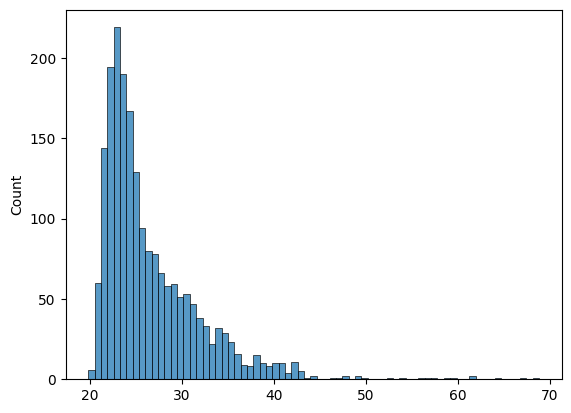

In [12]:
sns.histplot(gen_predicted_age_2000, bins = 71)

<Axes: ylabel='Count'>

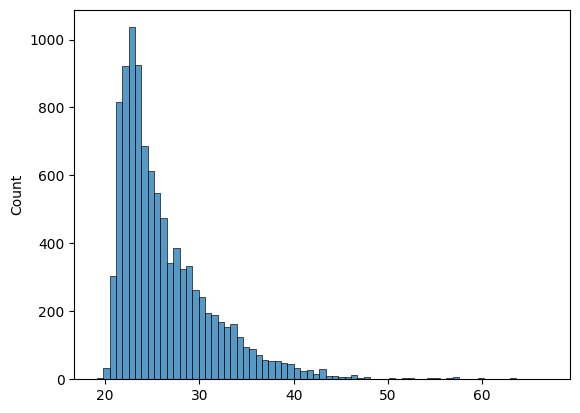

In [13]:
sns.histplot(gen_predicted_age_10000, bins = 71)

<Axes: ylabel='Count'>

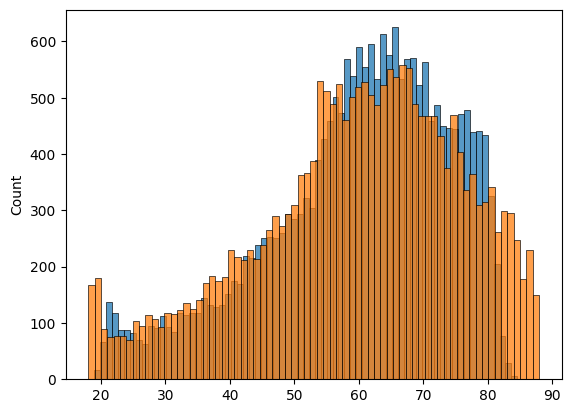

In [14]:
sns.histplot(predicted_age, bins = 71)
sns.histplot(Y_filtered, bins = 71)